In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter
from concurrent.futures import ThreadPoolExecutor
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import figaspect

import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
import scipy.stats as stats
from scipy.ndimage import gaussian_filter, zoom
from absl import app, flags
from IPython import get_ipython
from IPython.display import clear_output
from skimage import io, morphology, filters, util

import gc 
from absl import app, flags
import datetime
import os
import sys
import cv2
from IPython.display import clear_output
from IPython import get_ipython
import random
import pandas as pd

## Prepare Background Tiles

C:\Users\Leyang\Desktop\Han\LOCA_PRAM


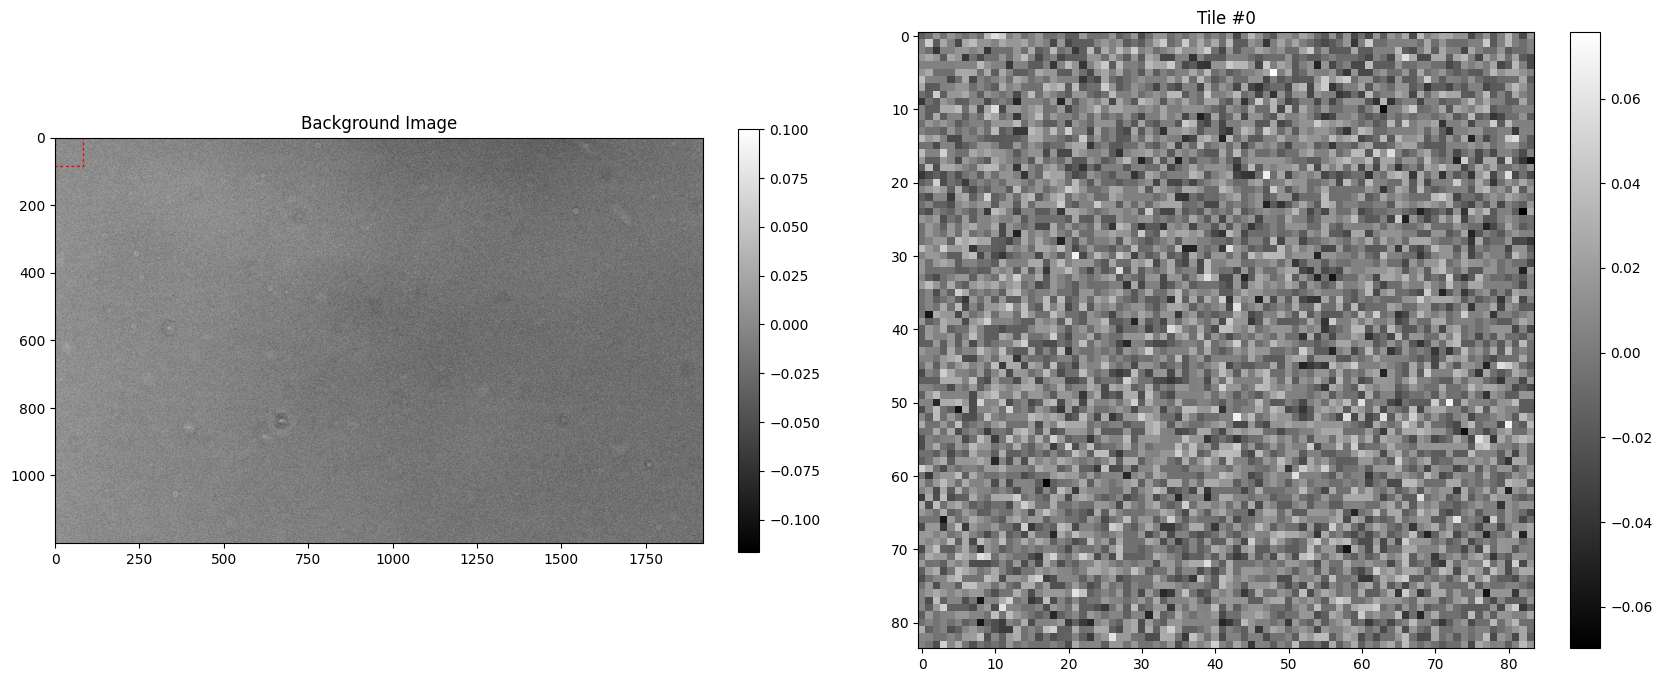

In [ ]:
def standardize_image(image):
    """
    Standardize the pixel values of a 16-bit image so that the resulting image
    has a mean of 0 and a standard deviation of 1.

    Parameters:
    - image: A NumPy array representing the 16-bit input image.

    Returns:
    - A NumPy array of the standardized image.
    """
    image = image.astype(np.float32) / 255.
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std
    print(f"mean: {mean}, std: {std}")
    return standardized_image

def shadow_remove(img):     
    """
    (Explanation needed)

    Parameters:
    - image: A NumPy array representing the 16-bit input image.

    Returns:
    - A NumPy array of the shadow removed image.
    """   
    dilated_img = morphology.dilation(img, morphology.square(11))
    bg_img = filters.median(dilated_img, morphology.disk(31))
    shadowremov = img - bg_img
    return shadowremov

def save_image(image):
    print(image.dtype)
    # Before saving, rescale and convert the processed image back to 16-bit
    final_img_16bit = rescale_to_16bit(image)
    cv2.imwrite('background_subtracted.png', final_img_16bit)

def rescale_to_16bit(image_float, target_range=(0, 65535)):
    """
    Rescales a floating-point image to the specified 16-bit range.

    Parameters:
    - image_float: A NumPy array of the image in floating-point format.
    - target_range: A tuple specifying the desired output range (min, max).

    Returns:
    - A NumPy array of the image rescaled to the 16-bit range.
    """
    min_val = np.min(image_float)
    max_val = np.max(image_float)
    scale = (target_range[1] - target_range[0]) / (max_val - min_val)
    image_16bit = (image_float - min_val) * scale + target_range[0]
    return image_16bit.astype(np.uint16)

def visualize_image(images, labels, backgrounds, image_index=0, figsize=(2000, 800)):
    """
    Visualize the images. 
    - image:            Number of training images generated. 
                        (num_imgs, 1, img_width, img_height)
    - background:       Previously generated "bg_tiles" is used. 
                        (num_imgs, 1, img_width, img_height)
    - labels:           One-hot representation of the center of the PSFs. 
                        (num_imgs, 1, img_width, img_height)
    - labels_density:   When "labels" are the one-hot representation, "label_density" has pixel value of 100 followed by smoothing with gaussian filter 
                        (num_imgs, 1, img_width, img_height)
    - image_index:      For sanity check, a single image from the training set is displayed. 
                        (int)
    - figsize:          Size of the figure. 
                        ex) (1000, 1000)
                        
    Returns:
    - None
    """   
    print(f"image index: {image_index}")
    num_imgs, img_channel, img_size_x, img_size_y = images.shape
    px = 1/plt.rcParams['figure.dpi'] 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(figsize[0]*px, figsize[1]*px))

    for i, ax in enumerate(axes.flatten()):
        D = np.squeeze(images[image_index, ...] )
        if not i % 4:
            GT = np.squeeze(labels[image_index, 2, ...] > 0)
            BG = np.squeeze(backgrounds[image_index, 0, ...])
            a = ax.imshow(D, origin='lower', cmap='gray')
            ax.set_title('Input Image')
        if i%4 == 1:
            a = ax.imshow(BG, origin='lower', cmap='gray')
            ax.set_title('Input Background')
        if i%4 == 2:
            a = ax.imshow(GT, origin='lower', cmap='gray')
            ax.set_title('Ground Truth Center')
            
        fig.colorbar(a, ax=ax, fraction=0.046)
        ax.set_xlim([0, img_size_x])
        ax.set_ylim([img_size_y, 0])

    plt.tight_layout()
    plt.show()
    
def prepare_background_tiles(root_folder, window_size):
    bg_image_subtracted_list = []

    for folder in os.listdir(root_folder):
        if 'bg' in folder: bg_path = os.path.join(root_folder, folder)
        bg_image_paths = os.listdir(bg_path)
        if bg_image_paths:
            for i, bg_image_path in enumerate(bg_image_paths):
                bg_image_path_complete = os.path.join(bg_path, bg_image_path)
                bg_image = np.asarray(Image.open(bg_image_path_complete).convert('L')).astype(np.float32)
                if i == 0:
                    bg_image_first_min = np.min(bg_image)
                    bg_image_first_max = np.max(bg_image)
                    bg_image_first_norm = (bg_image - bg_image_first_min) / (bg_image_first_max - bg_image_first_min)
                if i != 0:
                    bg_image_min = np.min(bg_image)
                    bg_image_max = np.max(bg_image)
                    bg_image_norm = (bg_image - bg_image_min) / (bg_image_max - bg_image_min)

                    bg_image_subtracted = bg_image_first_norm - bg_image_norm
                    bg_image_subtracted_list.append(bg_image_subtracted)

    bg_height, bg_width = bg_image_subtracted_list[0].shape
    bg_tiles = []
    for i, bg_image_norm in enumerate(bg_image_subtracted_list):
        for i in range(int(bg_height/window_size[0])):
            for j in range(int(bg_width/window_size[1])):
                bg_tile = bg_image_norm[i*window_size[0]: i*window_size[0] + window_size[0], 
                                j*window_size[1]: j*window_size[1] + window_size[1]]
                bg_tiles.append(bg_tile)
    bg_tiles = np.asarray(bg_tiles)
    
    index = 0
    fig, subplots = plt.subplots(1, 2, figsize=(20, 8))
    subplots[0].set_title("Background Image")
    subplot_0 = subplots[0].imshow(bg_image_subtracted_list[0], cmap='gray')
    rect = patches.Rectangle((window_size[0] * (index  % int(bg_width / window_size[0])), 
                              window_size[1] * (index // int(bg_width / window_size[1]))), 
                             window_size[0], window_size[1], linewidth=1, linestyle=(5, (2, 2)) ,edgecolor='r', facecolor='none')
    subplots[0].add_patch(rect)
    fig.colorbar(subplot_0, ax=subplots[0], fraction=0.03)
    subplot_1 = subplots[1].imshow(bg_tiles[index].squeeze(), cmap='gray')
    subplots[1].set_title(f"Tile #{index}")
    fig.colorbar(subplot_1, ax=subplots[1], fraction=0.05)
    
    return bg_tiles

os.chdir('C:/Users/Leyang/Desktop/Han/LOCA_PRAM/')
root_folder = 'images/'
window_size = (84, 84)
bg_tiles = prepare_background_tiles(root_folder, window_size)

## Authentic Image for Testing
### Sanity Check

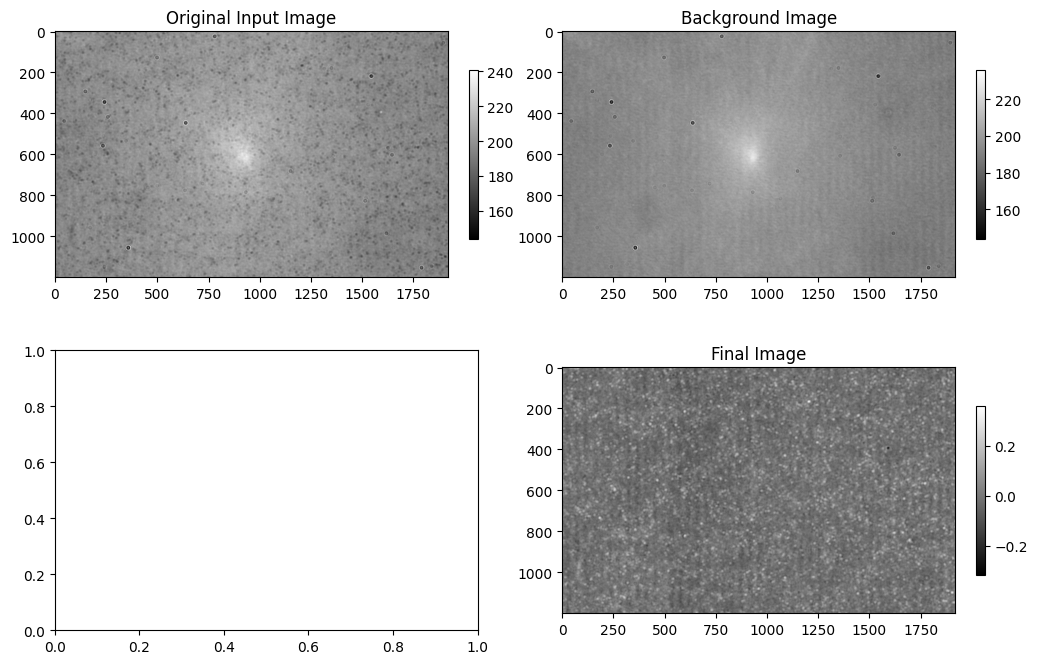

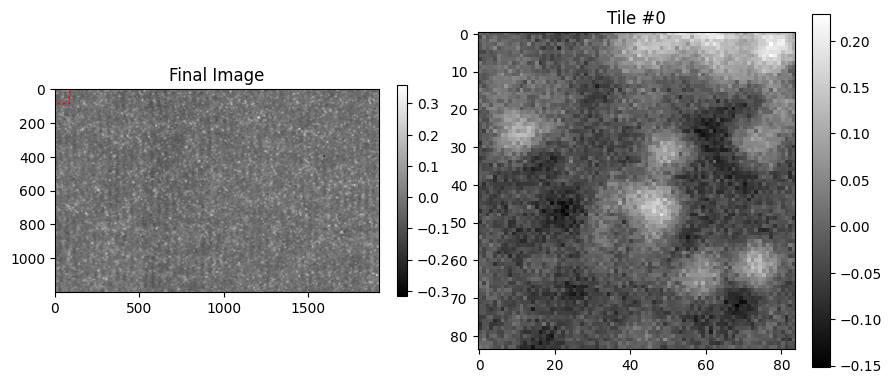

In [ ]:
def preprocess_bg_signal_images(bg_image, signal_image): 
  signal_image_min = np.min(signal_image)
  signal_image_max = np.max(signal_image)
  signal_image_norm = (signal_image - signal_image_min) / (signal_image_max - signal_image_min)
  bg_image_min = np.min(bg_image)
  bg_image_max = np.max(bg_image)
  bg_image_norm = (bg_image - bg_image_min) / (bg_image_max - bg_image_min)
  final_img = -(signal_image_norm - bg_image_norm)
  return final_img

img_path_01 = os.path.join(os.getcwd(), 'images/pc_example_01.png')
bg_path_01 = os.path.join(os.getcwd(), 'images/bg_example_01.png')
img_01 = np.asarray(Image.open(img_path_01).convert('L')).astype(np.float32)
bg_01 = np.asarray(Image.open(bg_path_01).convert('L')).astype(np.float32)
final_img = preprocess_bg_signal_images(bg_01, img_01)
final_img_height, final_img_width = final_img.shape

''' Sanity Check '''
figsize = (1200, 800)
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(figsize[0]*px, figsize[1]*px))
axes = axes.flatten()
a = axes[0].imshow(img_01, cmap='gray')
axes[0].set_title('Original Input Image')
fig.colorbar(a, ax=axes[0], fraction = 0.02)
b = axes[1].imshow(bg_01, cmap='gray')
axes[1].set_title('Background Image')
fig.colorbar(b, ax=axes[1], fraction= 0.02)
d = axes[3].imshow(final_img, cmap='gray')
axes[3].set_title('Final Image')
fig.colorbar(d, ax=axes[3], fraction= 0.02)
''' ------------ '''

image_tiles = []
for i in range(0, int(final_img_height/window_size[0])):
    for j in range(0, int(final_img_width/window_size[1])):
        image_tile = final_img[i * window_size[0] : i * window_size[0] + window_size[0], 
                               j * window_size[0] : j * window_size[0] + window_size[0]]
        image_tiles.append(image_tile)
image_tiles = np.asarray(image_tiles)

for i in range(1):
    index = i
    fig, subplots = plt.subplots(1, 2, figsize=(10, 6))
    subplot_0 = subplots[0].imshow(final_img, cmap='gray')
    subplots[0].set_title("Final Image")
    rect = patches.Rectangle((window_size[0] * (index  % int(final_img_width / window_size[0])), 
                              window_size[1] * (index // int(final_img_width / window_size[1]))), 
                              window_size[0], window_size[1], linewidth=1, linestyle=(5, (2, 2)), edgecolor='r', facecolor='none')
    subplots[0].add_patch(rect)
    fig.colorbar(subplot_0, ax=subplots[0], fraction=0.03)
    subplot_1 = subplots[1].imshow(image_tiles[index].squeeze(), cmap='gray')
    subplots[1].set_title(f"Tile #{index}")
    fig.colorbar(subplot_1, ax=subplots[1], fraction=0.05)

## Training Data Generation

image index: 0


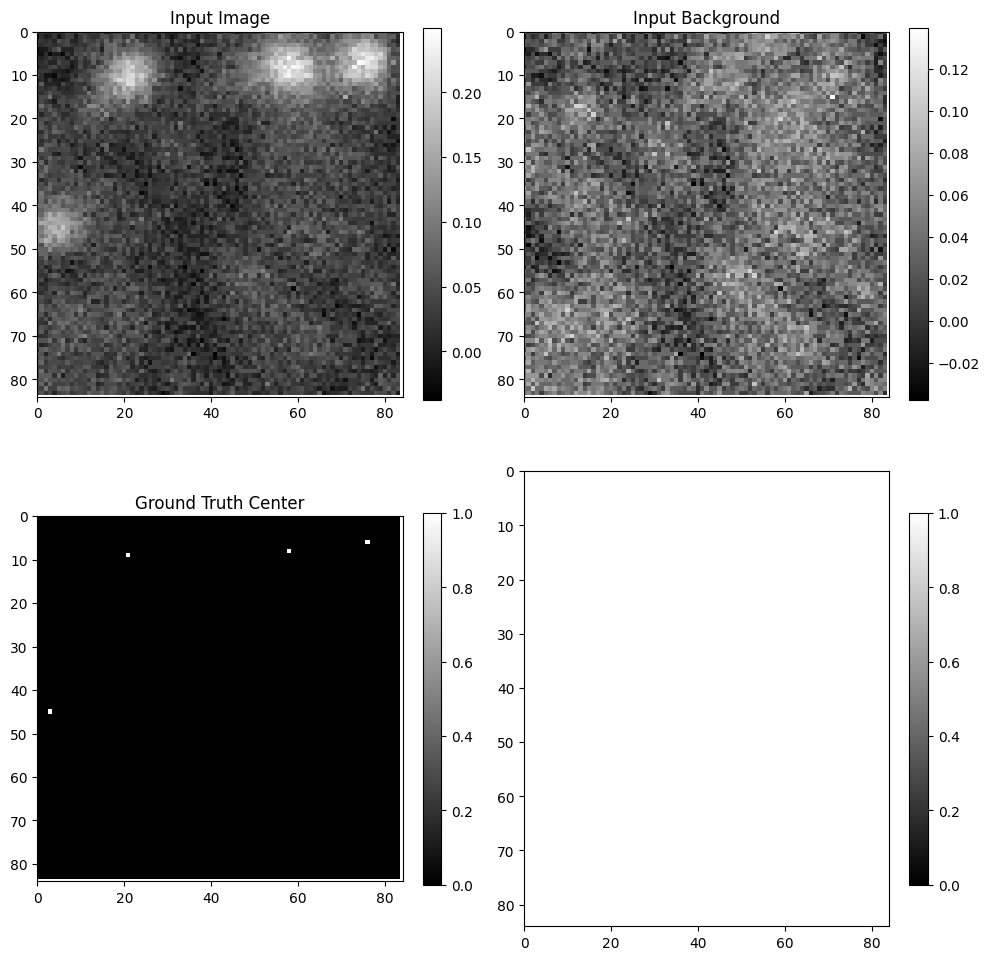

image index: 1


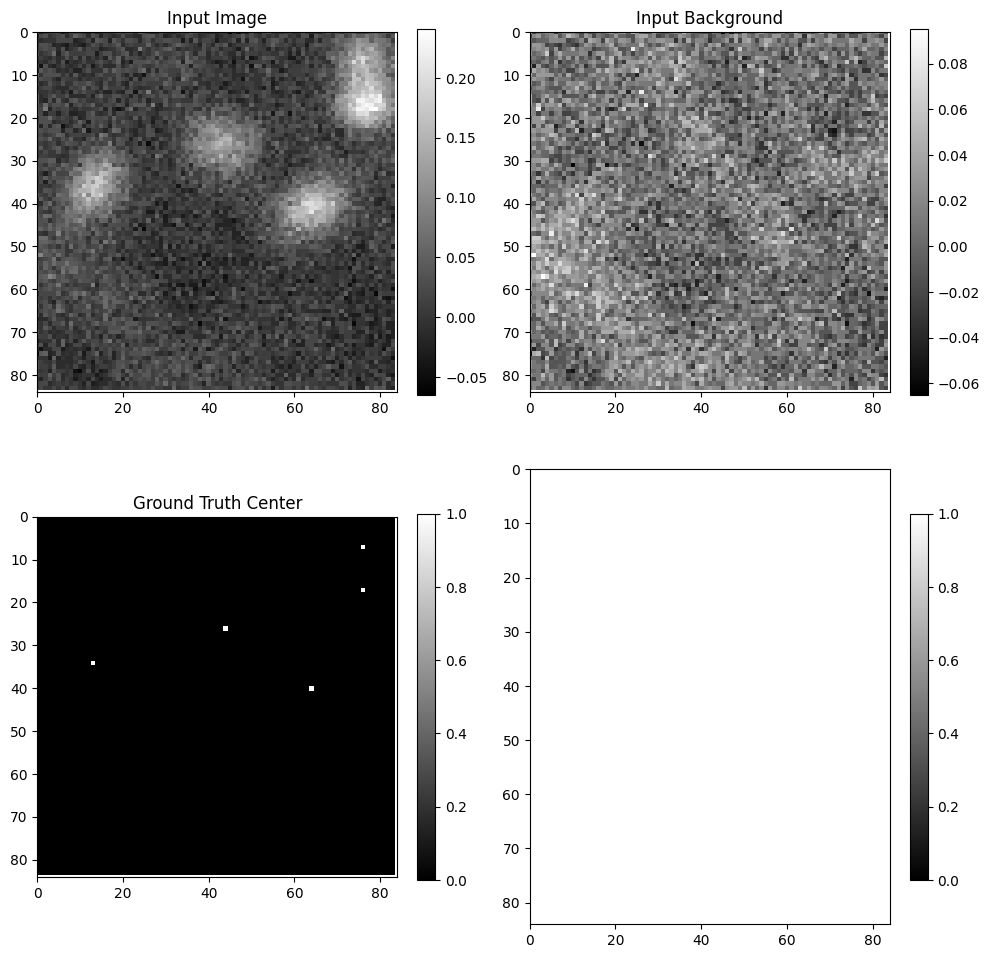

image index: 2


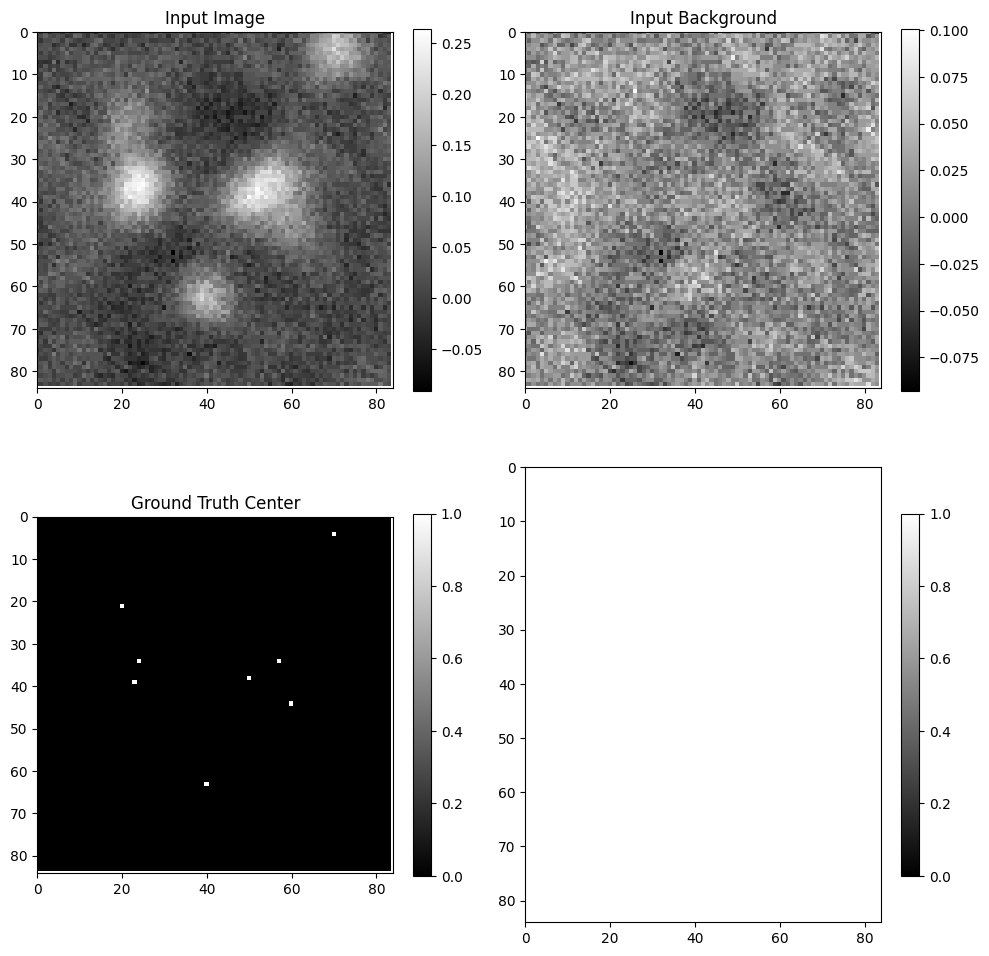

image index: 3


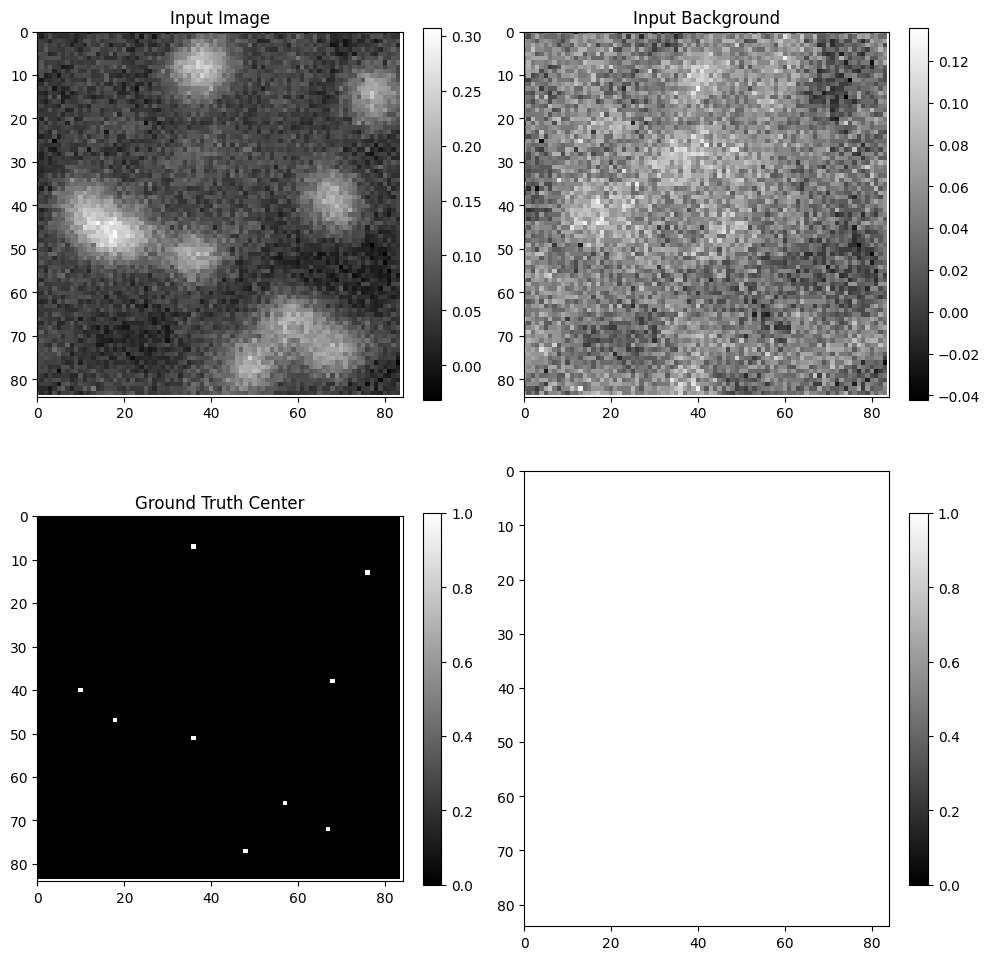

image index: 4


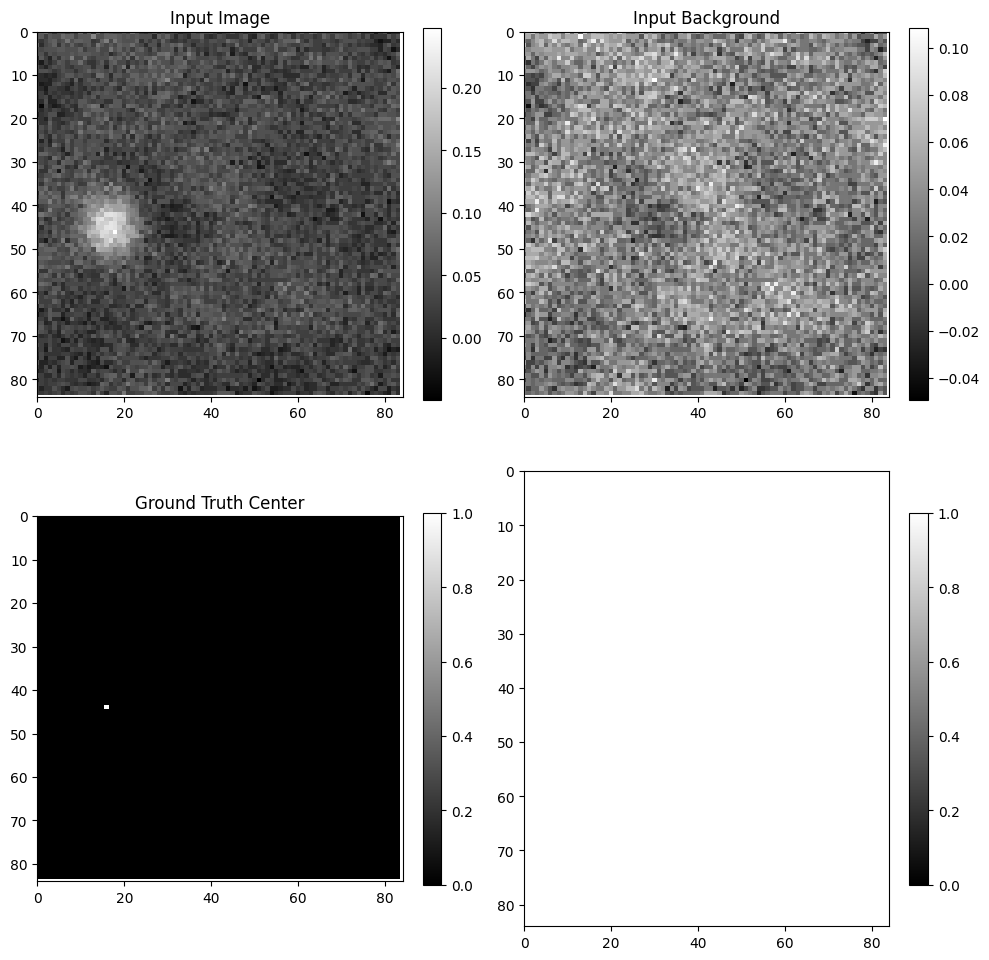

In [33]:
# Function to simulate an image with signal
def generate_simulation_image(num_imgs, img_size, bg_tiles, num_gaus_low=1, num_gaus_high=50, labels_channel=3, save_image=False, save_image_path=os.path.join(os.getcwd(), 'simulated_images')):
        
    # initialize tensors containing images and labels 
    images = torch.zeros(num_imgs, 1, img_size[1], img_size[0])
    labels = torch.zeros(num_imgs, labels_channel, img_size[1], img_size[0])
    backgrounds = torch.zeros(num_imgs, 1, img_size[1], img_size[0])

    x = np.linspace(start=0, stop=img_size[0], num=img_size[0], endpoint=False)
    y = np.linspace(start=0, stop=img_size[1], num=img_size[1], endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="xy")
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    offset_params = (0.19, 0.06)
    sigma_x_params = (5.27, 0.58) 
    sigma_y_params = (4.39, 0.34) 
    amplitude_params = (20., 2.64) 
    
    weibull_beta = 1.9038
    weibull_alpha = 7.3037
    weibull_hard_cutoff = 10.0
    c = 5.8488
    
    centers = []  # To store the center information for comparison with MatLab code (conventional)
    for i in range(num_imgs):
        label = torch.zeros(labels_channel, img_size[1], img_size[0])
        gauss = torch.zeros(img_size[1], img_size[0], dtype=torch.float64)
        num_gauss = np.random.randint(low=num_gaus_low, high=num_gaus_high)
        
        bg_random_indices = np.random.randint(low=0, high=bg_tiles.shape[0])
        background = bg_tiles[bg_random_indices]
        background = torch.from_numpy(background)
    
        used_locations = []
        for k in range(num_gauss):
            while True:
                loc_padding = 3
                loc_x = np.random.uniform(low=loc_padding, high=img_size[0] - loc_padding)
                loc_y = np.random.uniform(low=loc_padding, high=img_size[1] - loc_padding)
                loc = (int(loc_y), int(loc_x))
                
                min_distance = 5  
                if all(np.sqrt((loc[0] - used_loc[0])**2 + (loc[1] - used_loc[1])**2) >= min_distance for used_loc in used_locations):
                    used_locations.append(loc)
                    break

            sigma_x = np.abs(sigma_x_params[1] * np.random.randn() + sigma_x_params[0])
            sigma_y = np.abs(sigma_y_params[1] * np.random.randn() + sigma_y_params[0])
            sigma_x = np.round(sigma_x, 4)
            sigma_y = np.round(sigma_y, 4)
            sigma_x = np.clip(sigma_x, 3., np.inf)  # Ensure sigma_x isn't too small
            sigma_y = np.clip(sigma_y, 3., np.inf)  # Ensure sigma_y isn't too small
    
            gauss_random_amplitudes = (amplitude_params[1] * np.random.randn()) + amplitude_params[0]
            gauss_random_amplitudes = np.round(gauss_random_amplitudes, 4)
            gauss_random_amplitudes = np.clip(gauss_random_amplitudes, 10, np.inf)
            # gauss_random_amplitudes_weibull = stats.weibull_min.rvs(weibull_beta, scale=weibull_alpha, loc=c, size=3)
            # gauss_random_amplitudes_weibull = gauss_random_amplitudes_weibull[gauss_random_amplitudes_weibull > weibull_hard_cutoff]
            # gauss_random_amplitudes_weibull = gauss_random_amplitudes_weibull[-1] if gauss_random_amplitudes_weibull.size >= 1 else weibull_hard_cutoff    
            # gauss_random_amplitudes_weibull = np.round(gauss_random_amplitudes_weibull, 4)
            
            gauss_random_offsets = np.abs(offset_params[1] * np.random.randn() + offset_params[0]) # not used
            
            theta = np.random.randint(low=-90, high=90) * (np.pi/180)
            R = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            covariance = np.asarray([[sigma_y ** 2, 0],[0, sigma_x ** 2]])
            covariance_prime = R @ covariance @ R.T
            rv = multivariate_normal([loc_x, loc_y], covariance_prime)
            
            gauss += (gauss_random_amplitudes * (rv.pdf(pos)))
            label[0, int(loc_y), int(loc_x)] += (loc_x - int(loc_x)) - 0.5
            label[1, int(loc_y), int(loc_x)] += (loc_y - int(loc_y)) - 0.5
            label[2, int(loc_y), int(loc_x)] += gauss_random_amplitudes
        
        gauss = (1)*gauss + background

        # Add to the tensor
        images[i, ...] = torch.Tensor(gauss).view(1, img_size[1], img_size[0])
        labels[i, ...] = torch.Tensor(label).view(labels_channel, img_size[1], img_size[0])
        backgrounds[i, ...] = torch.Tensor(background).view(1, img_size[1], img_size[0])
        labels_combined = torch.cat((labels, backgrounds), dim=1)
        
        if save_image:
            if not os.path.exists(save_image_path):
                os.makedirs(save_image_path)
            img = Image.fromarray(np.uint8(np.clip(gauss, 0, 255)*255))
            save_path = os.path.join(save_image_path, f'simulated_image_{i:03}.png')
            img.save(save_path)
                
            centers.append(used_locations)
        
    return images, labels_combined, centers

num_images = 100
num_gaus_low = 1
num_gaus_high = 10
labels_channel = 3
training_images, labels_combined, centers_info = generate_simulation_image(num_imgs=num_images,
                                                                           img_size=window_size, 
                                                                           bg_tiles=bg_tiles, 
                                                                           num_gaus_low=num_gaus_low, 
                                                                           num_gaus_high=num_gaus_high, 
                                                                           labels_channel=labels_channel, 
                                                                           save_image=True, 
                                                                           save_image_path='simulated_images_for_comparison_with_conv')

# # Convert center information to DataFrame and save to Excel for comparison with MatLab code (conventional algorithm)
# center_data = []
# for i, locations in enumerate(centers_info):
#     for loc in locations:
#         center_data.append({'Image Index': i, 'Location Y': loc[0], 'Location X': loc[1]})

# df = pd.DataFrame(center_data)
# df.to_excel('center_information.xlsx', index=False)

''' Sanity Check '''
for i in range(5):
    image_index = i
    visualize_image(images=training_images, 
                    labels=labels_combined[:,[0,1,2],...], 
                    backgrounds=labels_combined[:,[3],...], 
                    image_index=image_index, figsize=(1000, 1000))

### Asynchronous Dataset Loading

Time taken to generate images: 0.37 seconds


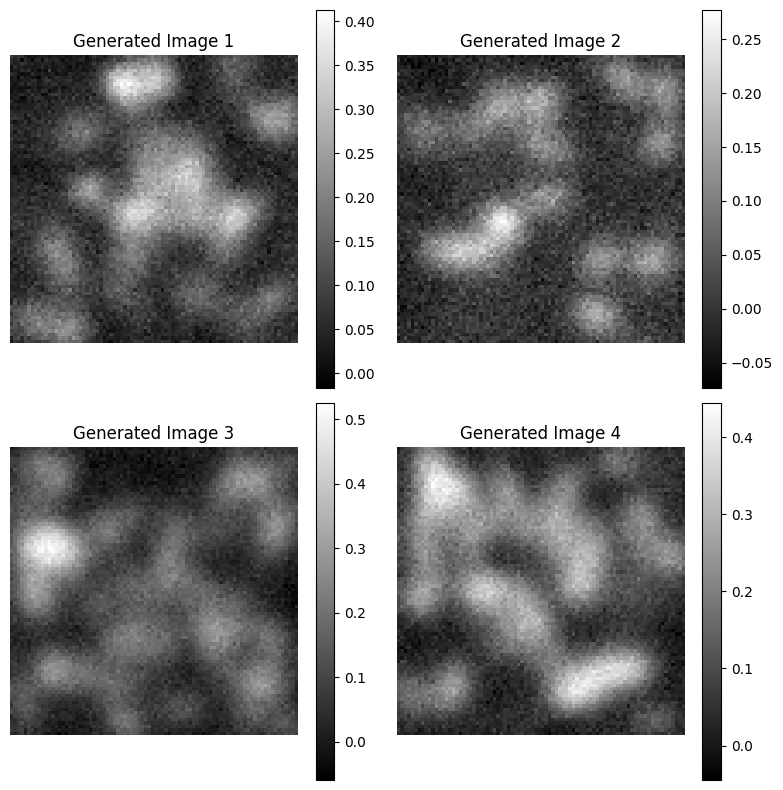

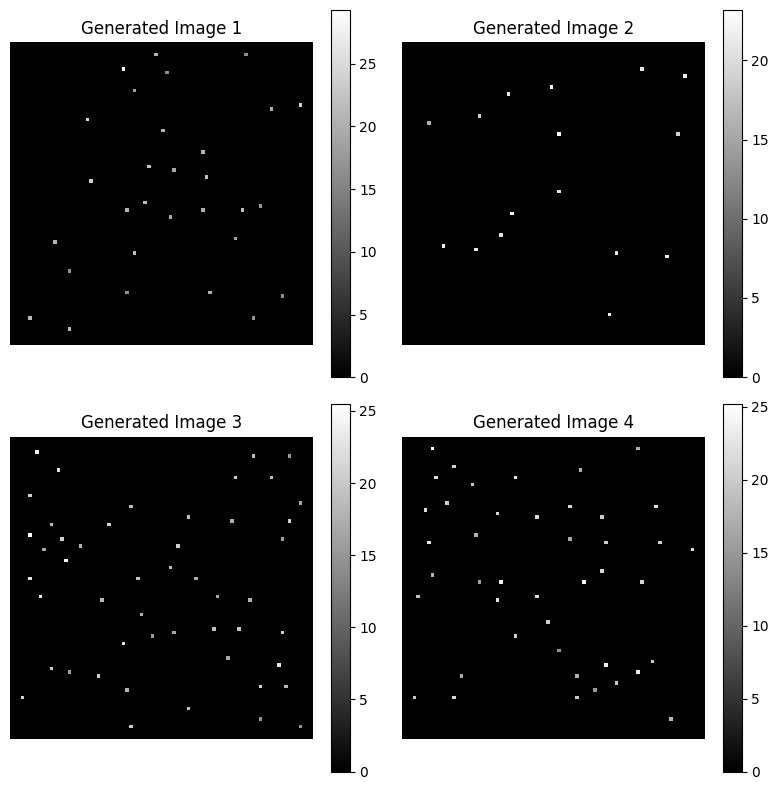

In [35]:
class GaussianDataset(Dataset):
    def __init__(self, num_batches, num_images_per_batch, bg_tiles, img_size=(84, 84), transform=None):
        self.transform = transform
        self.num_batches = num_batches
        self.num_images_per_batch = num_images_per_batch
        self.bg_tiles = bg_tiles
        self.img_size = img_size
        
        # Pre-generate all batches
        self.batches = self._generate_all_batches()

    def _generate_all_batches(self):
        """Generate all batches of images asynchronously."""
        all_batches = []
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = [executor.submit(generate_simulation_image, self.num_images_per_batch, self.img_size, self.bg_tiles) for _ in range(self.num_batches)]
            for future in futures:
                all_batches.append(future.result())  # Collect all generated batches
        return all_batches

    def __len__(self):
        return self.num_batches * self.num_images_per_batch  # Total number of images

    def __getitem__(self, idx):
        batch_idx = idx // self.num_images_per_batch  # Determine which batch to use
        image_idx = idx % self.num_images_per_batch  # Determine index within the batch
        
        images, labels_combined, _ = self.batches[batch_idx]
        
        image = images[image_idx]
        label = labels_combined[image_idx, [0, 1, 2], ...]
        background = labels_combined[image_idx, [3], ...]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, background

# Asynchronous data loading function for batches
def async_load_batch(data_loader):
    """Load batches asynchronously using a thread pool."""
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(load_batch, batch) for batch in data_loader]
        for future in futures:
            yield future.result()

def load_batch(batch):
    """Simulate batch loading (you can customize this to fit your process)."""
    time.sleep(0.1)  # Simulate a delay (remove or adjust depending on your loading time)
    return batch

# Sanity Check: Visualizing asynchronously generated data
def sanity_check(images):
    plt.figure(figsize=(8, 8))
    # Loop over generated data for visualization and checking
    for i in range(images.shape[0]):
        if i < 4 :
            plt.subplot(2, 2, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.colorbar()
            plt.title(f"Generated Image {i+1}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


# Start the timer
start_time = time.time()

batch_size = 32
num_image_per_batch = 1
dataset = GaussianDataset(num_batches=batch_size, num_images_per_batch=num_image_per_batch, bg_tiles=bg_tiles)  # Generate a sufficient number of images
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Stop the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Time taken to generate images: {duration:.2f} seconds")

for batch_idx, (images, label, backgrounds) in enumerate(dataloader):
    # Perform the sanity check with 8 generated images
    sanity_check(images)
    sanity_check(label[:,[2],...])

## Construct single frame DECODE model

In [37]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1, norm_groups=8):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same', bias=True),
            nn.GroupNorm(num_groups=norm_groups, num_channels=out_channels),
            nn.ELU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same', bias=True),
            nn.GroupNorm(num_groups=norm_groups, num_channels=out_channels),
            nn.ELU(),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class up_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1, norm_groups=8):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same', bias=True),
        )
        
    def forward(self, x):
        x = self.up(x)
        return x
    
class multi_head(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1, norm_groups=8):
        super(multi_head, self).__init__()

        self.multi_head = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding='same', bias=True),
            nn.GroupNorm(num_groups=norm_groups, num_channels=in_channels),
            nn.ELU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding='same', bias=True)
        )
    
    def forward(self, x):
        x = self.multi_head(x)
        return x

class GaussianMixtureModel(nn.Module):
    def __init__(self, num_channels) -> None:
        super(GaussianMixtureModel, self).__init__()
        self.out_channels_heads = (1, 3, 3, 1)
        self.num_channels = num_channels

        self.Conv1 = conv_block(in_channels=num_channels, out_channels=48, dropout=0.1)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv2 = conv_block(in_channels=48, out_channels=96, dropout=0.1)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Conv3 = conv_block(in_channels=96, out_channels=192, dropout=0.1)

        self.Up2 = up_conv(in_channels=192, out_channels=96)
        self.Up_conv2 = conv_block(in_channels=192, out_channels=96, dropout=0.1)
        
        self.Up1 = up_conv(in_channels=96,out_channels=48)
        self.Up_conv1 = conv_block(in_channels=96, out_channels=48, dropout=0.1)
        
        self.dropout = nn.Dropout2d(p=0.3)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.sigma_eps = 0.001
        
        self.mt_heads = torch.nn.ModuleList(
            [multi_head(in_channels=48, out_channels=ch_out) for ch_out in self.out_channels_heads]
            )
        
        # Apply Kaiming initialization to all layers
        self.initialize_weights()
        
    def initialize_weights(self):
        """Apply Kaiming initialization to the model weights."""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):  # Apply Kaiming initialization to Conv2d and Linear layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, training):
        x1 = self.Conv1(x)
        x2 = self.Maxpool1(x1)
        x2 = self.Conv2(x2)
        x3 = self.Maxpool2(x2)
        x3 = self.Conv3(x3)

        d2 = self.Up2(x3)
        d2 = torch.cat((x2,d2),dim=1)
        d2 = self.Up_conv2(d2)
        
        d1 = self.Up1(d2)
        d1 = torch.cat((x1,d1),dim=1)
        d1 = self.Up_conv1(d1)
        
        d = [mt_head.forward(d1) for mt_head in self.mt_heads]
        
        p = torch.sigmoid(torch.clamp(d[0], min=-8.0, max=8.0))
        pxyn_mean = d[1]
        pxyn_mean[:,[0,1],...] = torch.tanh(pxyn_mean[:,[0,1],...])
        pxyn_mean[:,[2],...] = torch.sigmoid(pxyn_mean[:,[2],...]) * 25
        pxy_std = torch.sigmoid(d[2]) * 3 + self.sigma_eps
        bg = torch.tanh(d[3]) * 3 + self.sigma_eps

        return p, pxyn_mean, pxy_std, bg

def target_extract(labels, p_indices, xy_coord):
    batch_size = labels.shape[0]
    labels[:, [0, 1], ...] = labels[:, [0, 1], ...] + xy_coord
    target_xyn_reshaped = labels[p_indices[0], :, p_indices[2], p_indices[3]].reshape(batch_size, -1, 3)
    return target_xyn_reshaped
    
class GMMLoss(nn.Module):
    def __init__(self, img_size, device) -> None:
        super(GMMLoss, self).__init__()
        self._p_loss = nn.MSELoss()
        self._bg_loss = nn.MSELoss()
        self._px_loss = nn.CrossEntropyLoss()
        self._py_loss = nn.CrossEntropyLoss()
        self._density_loss = nn.MSELoss()
        x_coord = torch.linspace(start=0.0, end=img_size, steps=img_size+1)[:-1].unsqueeze(0) + 0.5
        y_coord = torch.linspace(start=0.0, end=img_size, steps=img_size+1)[:-1].unsqueeze(1) + 0.5
        self._xy_coord = torch.cat((
            x_coord.expand(1, 1, img_size, img_size),
            y_coord.expand(1, 1, img_size, img_size)
        ), 1).to(device=device)
        
    def check_for_nan_inf(self, tensor, name="Tensor"):
        if torch.isnan(tensor).any():
            print(f"NaN found in {name}")
        if torch.isinf(tensor).any():
            print(f"Inf found in {name}")

    def forward(self, p, pxyn_mean, pxy_std, bg, labels, labels_bg):
        '''
        Args:
            p: size N x C=1 x H x W (Sigmoid applied)
            pxy_mean: size N x C=3 x H x W 
            pxy_var: size N x C=3 x H x W 
            bg: size N x C=1 x H x W (Sigmoid applied)
            labels: size N x C=1 x H x W 
            labels_bg: size N x C=1 x H x W

            mask: size N
        '''
        
        # Apply this check in key parts of your model and loss function
        self.check_for_nan_inf(p, "p")
        self.check_for_nan_inf(pxyn_mean, "pxyn_mean")
        self.check_for_nan_inf(pxy_std, "pxy_std")
        
        count_loss = 0
        gmm_loss = 0
        bg_loss = 0
        
        batch_size = p.shape[0]
        labels_intensity = labels[:,[2],...] > 0
        
        p_sum = p.sum(-1).sum(-1)
        p_bernuilli_var = (p - p ** 2).sum(-1).sum(-1)
        p_gauss = torch.distributions.Normal(p_sum, torch.sqrt(p_bernuilli_var))
        count = labels_intensity.sum(-1).sum(-1)
        count_loss = count_loss + (p_gauss.log_prob(count) * count)

        p_normed = p / p.sum(-1).sum(-1).view(-1, 1, 1, 1)
        p_indices = tuple((p+1).nonzero(as_tuple=False).transpose(1,0))
        p_probs = p_normed[p_indices].reshape(batch_size, -1)
        # p_probs = p_probs / (p_probs.sum(dim=-1, keepdim=True) + 1e-3)
        
        pxyn_mean = pxyn_mean.clone()
        pxyn_mean[:, [0, 1], ...] = pxyn_mean[:, [0, 1], ...] + self._xy_coord
        pxyn_mean = pxyn_mean[p_indices[0], :, p_indices[2], p_indices[3]].reshape(batch_size, -1, labels_channel)
        pxy_std = pxy_std[p_indices[0], :, p_indices[2], p_indices[3]].reshape(batch_size, -1, labels_channel)
        
        mix = torch.distributions.Categorical(p_probs)
        comp = torch.distributions.Independent(torch.distributions.Normal(pxyn_mean, pxy_std), 1)
        gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

        xyn_tar = target_extract(labels=labels, p_indices=p_indices, xy_coord=self._xy_coord)
        # xy_tar = xyn_tar[:,:,[0,1]]
        mask = (xyn_tar[:,:,[2]] > 0).squeeze()
        
        if count.sum():
            gmm_log = gmm.log_prob(xyn_tar.transpose(0,1)).transpose(0,1)
            gmm_log = (gmm_log * mask).sum(-1)
            gmm_loss = gmm_loss + gmm_log

        bg_loss = bg_loss + self._bg_loss(bg.squeeze(), labels_bg.squeeze())

        return -count_loss, -gmm_loss, bg_loss

## Construct train function

In [38]:
def visualize_result(epoch, GT, images, labels_bg, p, pxy_mean, pxy_std, true_counts_list, predicted_counts_p_list, save_image=False, output_dir=None, eval=False):
  fig_key = ['IMG', 
             'LABEL_GT', 
             'P_COUNT', 
             'X_MEAN', 
             'Y_MEAN', 
             'INTENSI',
             'X_VAR', 
             'Y_VAR', 
             'I_VAR',
             ]
  fig_dict = {'IMG'     : images[-1].to('cpu'), 
              'LABEL_GT': GT[-1, ...].to('cpu') > 0, 
              'P_COUNT' : p[-1].detach().to('cpu').numpy(),
              'X_MEAN'  : pxy_mean[-1, 0, ...].detach().to('cpu').numpy(), 
              'Y_MEAN'  : pxy_mean[-1, 1, ...].detach().to('cpu').numpy(),
              'INTENSI' : pxy_mean[-1, 2, ...].detach().to('cpu').numpy(),
              'X_VAR'   : pxy_std[-1, 0, ...].detach().to('cpu').numpy(), 
              'Y_VAR'   : pxy_std[-1, 1, ...].detach().to('cpu').numpy(),
              'I_VAR'   : pxy_std[-1, 2, ...].detach().to('cpu').numpy(),
              }
    
  if not epoch % 30:
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, axs = plt.subplots(2,5, figsize=(2000*px, 800*px))
    for i, ax in enumerate(axs.flatten()):
      if i == 9: 
        true_line = [[0, max(true_counts_list)]] * 2
        ax.set_title("Valid")
        ax.set_xlabel("True Counts")
        ax.set_ylabel("Predicted Counts")
        ax.plot(*true_line, 'r-')
        ax.scatter(true_counts_list, predicted_counts_p_list, s=3, c="red")
        continue
      IMG = np.squeeze(fig_dict[fig_key[i]])
      a = ax.imshow(IMG)
      ax.set_title(fig_key[i])
      fig.colorbar(a, ax=ax)
    if save_image:
      if eval:
          save_dir = f'{output_dir}/{epoch}_epoch_eval.png'
      else:
          save_dir = f'{output_dir}/{epoch}_epoch_train.png'
      plt.savefig(save_dir, dpi=600)
    # plt.show()
    
    if not epoch % 100:
      plt.show()
    else:
      plt.close()

def evaluate(model, loss_fun, data_loader, device, epoch, output_dir):
  model.eval()
  loss = 0
  true_counts_list, predicted_counts_density_list, predicted_counts_p_list = [], [], []
  with torch.no_grad():
    for images, labels, labels_bg in data_loader:
      images, labels, labels_bg = images.to(device=device), labels.to(device=device), labels_bg.to(device=device)
      p, pxy_mean, pxy_std, bg = model(images, training=False)
      log_p_gauss, log_gmm, bg_loss = loss_fun(p, pxy_mean, pxy_std, bg, labels, labels_bg)
      loss += (log_p_gauss + log_gmm + bg_loss).mean()

      for GT, p in zip(labels[:,[-1],...] > 0, p):
        true_counts = torch.sum(GT).item()
        predicted_counts_p = torch.sum(p > 0.6).item()
        true_counts_list.append(true_counts)
        predicted_counts_p_list.append(predicted_counts_p)
        
  visualize_result(epoch, GT, images, labels_bg, p, pxy_mean, pxy_std, true_counts_list, predicted_counts_p_list, save_image=True, output_dir=output_dir, eval=True)

  return loss

# Function that trains the model
def train(model, num_epoch, optimizer, scheduler, loss_fun, device, writer, output_dir):
  # create a new model
  model.to(device=device)
  # initialize losses
  train_loss = torch.zeros(num_epoch)
  test_loss  = torch.zeros(num_epoch)
  best_loss = np.inf  # Initialize best loss

  pbar = tqdm(range(num_epoch))
  for epoch in pbar:
    epoch_start_time = time.time()

    model.train()
    batch_loss_list = []
    count_loss_list, gmm_loss_list, bg_loss_list = [], [], []
    true_counts_list, predicted_counts_p_list = [], []

    batch_size = 60
    num_image_per_batch = 10
    train_dataset = GaussianDataset(num_batches=batch_size, num_images_per_batch=num_image_per_batch, bg_tiles=bg_tiles)  # Generate a sufficient number of images
    train_dataloader = DataLoader(train_dataset, batch_size=num_image_per_batch, shuffle=True)
    
    for i, (images, labels, labels_bg) in enumerate(train_dataloader):
      start_time = time.time()

      images, labels, labels_bg = images.to(device=device), labels.to(device), labels_bg.to(device)
      
      p, pxy_mean, pxy_std, bg = model(images, training=True)
      count_loss, gmm_loss, bg_loss = loss_fun(p, pxy_mean, pxy_std, bg, labels, labels_bg)
      loss = count_loss + gmm_loss + bg_loss
      
      loss.mean().backward()
      optimizer.step()
      optimizer.zero_grad()
      
      batch_loss_list.append(loss.mean().item())
      count_loss_list.append(count_loss.mean().item())
      gmm_loss_list.append(gmm_loss.mean().item())
      bg_loss_list.append(bg_loss.mean().item())
      
      for GT, p in zip(labels[:,[-1],...] > 0, p):
        true_counts = torch.sum(GT).item()
        predicted_counts_p = torch.sum(p).item()

        true_counts_list.append(true_counts)
        predicted_counts_p_list.append(predicted_counts_p)
      
      end_time = time.time()
      per_batch_time = end_time - start_time

    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    visualize_result(epoch, GT, images, labels_bg, p, pxy_mean, pxy_std, true_counts_list, predicted_counts_p_list, save_image=True, output_dir=output_dir, eval=False)
      
    scheduler.step()
    lr = scheduler.get_last_lr()[0]
    train_loss[epoch] = np.mean(batch_loss_list)

    batch_size = 30
    num_image_per_batch = 10
    eval_dataset = GaussianDataset(num_batches=batch_size, num_images_per_batch=num_image_per_batch, bg_tiles=bg_tiles)  # Generate a sufficient number of images
    eval_dataloader = DataLoader(eval_dataset, batch_size=num_image_per_batch, shuffle=True)

    loss_test = evaluate(model=model, loss_fun=loss_fun, data_loader=eval_dataloader, device=device, epoch=epoch, output_dir=output_dir)
    test_loss[epoch] = loss_test.item()
    
    writer.add_scalar('count_loss', np.mean(count_loss_list), epoch + 1)   
    writer.add_scalar('gmm_loss', np.mean(gmm_loss_list), epoch + 1) 
    writer.add_scalar('bg_loss', np.mean(bg_loss_list), epoch + 1)
    writer.add_scalar('train_loss', train_loss[epoch], epoch + 1)
    writer.add_scalar('test_loss', test_loss[epoch], epoch + 1)
    writer.add_scalar('lr', lr, epoch + 1)
    pbar.set_description(f"Epoch {epoch+1}, LR {lr}, Loss {batch_loss_list[-1]:.4f}")
    
    best_loss = np.inf # this line is added to save weights for all epoch
    # Save trained parameter
    if loss_test < best_loss:
      best_loss = loss_test
      current_time = datetime.datetime.now().strftime('%Y.%m.%d_%H.%M.%S')
      torch.save(model.state_dict(), f'{output_dir}/LOCA_PRAM_{current_time}_{epoch}_outof_{num_epoch}.pth')

  return train_loss, test_loss, model

## Main

In [ ]:
from torch.distributions import Distribution
Distribution.set_default_validate_args(False)

learning_rate = 6e-4
momentum = 0.9
weight_decay = 0.1
gamma = 0.1
current_time = datetime.datetime.now().strftime('%Y.%m.%d_%H.%M.%S')
output_dir = 'runs/' + current_time + '/'
batch_size = batch_size
seed = 2
max_epoch = 1750
in_channel = 1
milestones = [1000, 1250, 1500]
linear_lr_scheduler_max = 250
window_size = (84, 84)

torch.manual_seed(seed)

gc.collect()
torch.cuda.empty_cache()
# torch.mps.empty_cache

model = GaussianMixtureModel(num_channels=in_channel)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")
print(f" Current device is: {device}")

loss_fun = GMMLoss(img_size=window_size[0], device=device)
model.to(device)
writer      = SummaryWriter(output_dir, flush_secs=10)
optimizer   = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 1e-9, total_iters=linear_lr_scheduler_max)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1, scheduler2])

train_loss, test_loss, model = train(model=model, 
                                        num_epoch=max_epoch, 
                                        optimizer=optimizer, 
                                        scheduler=scheduler, 
                                        loss_fun=loss_fun, 
                                        device=device,
                                        writer=writer,
                                        output_dir=output_dir,
                                        )

plt.plot(train_loss,'s-',label='Train')
plt.plot(test_loss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%test_loss[-1])
plt.show()

## Clear cache

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

## Test the trained model

cpu


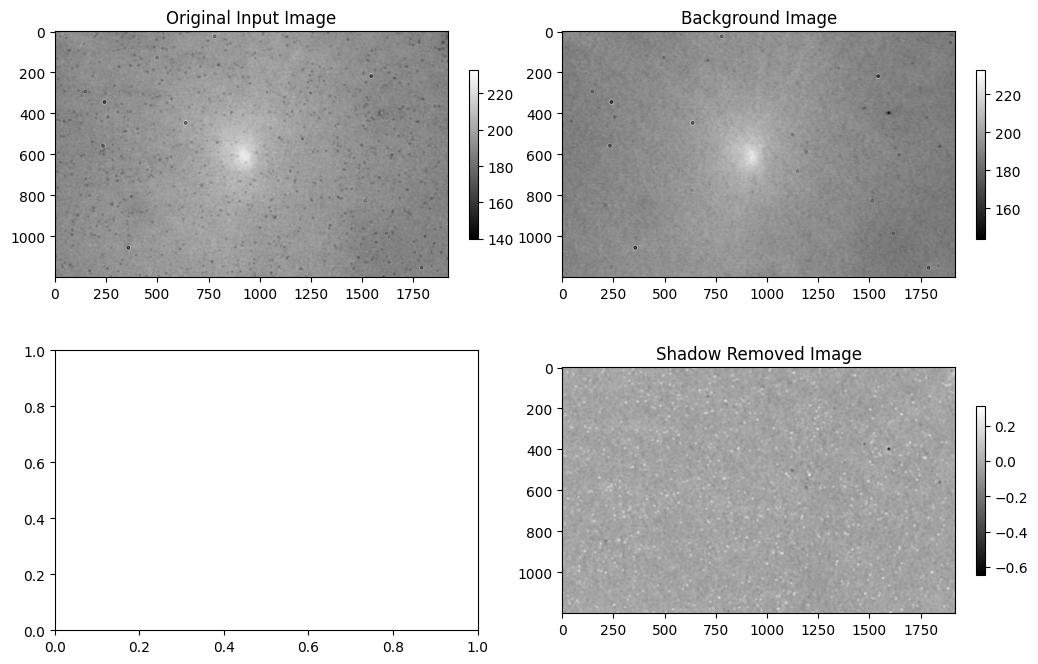

In [ ]:
def test(model, original_image, test_image, window_size, device, p_threshold, show_image=True, labels=None, computation_time_analysis=False):
   
  model.eval()
  if len(test_image.shape) == 3:
    test_image = test_image.squeeze()
    original_image = original_image.squeeze()
  test_image_height, test_image_width = test_image.shape
 
  test_img_tiles = []
# Calculate the number of tiles needed for the test image
  height_factor = (test_image_height + window_size[0] - 1) // window_size[0]
  width_factor = (test_image_width + window_size[1] - 1) // window_size[1]
  
  # Fill the test_img_tiles with actual tiles and zero tensors
  for i in range(height_factor):
      for j in range(width_factor):
          # Calculate the slice for the current tile
          tile = test_image[i * window_size[0]: (i + 1) * window_size[0], 
                            j * window_size[1]: (j + 1) * window_size[1]]
          
          # If the tile is smaller than the window size, pad it with zeros
          if tile.shape[0] < window_size[0] or tile.shape[1] < window_size[1]:
            padded_tile = np.zeros(window_size)
            padded_tile[:tile.shape[0], :tile.shape[1]] = tile
            test_img_tiles.append(padded_tile)
          else:
            test_img_tiles.append(tile)
          
  test_img_tiles = torch.from_numpy(np.asarray(test_img_tiles)).unsqueeze(1).float().to(device=device)
  
  if computation_time_analysis:
    test_img_tiles = test_img_tiles[0, ...].unsqueeze(0)

  with torch.no_grad():
    true_counts_list, predicted_counts_density_list, predicted_counts_p_list = [], [], []

    test_img_tiles = test_img_tiles.to(device=device)
    p, pxy_mean, pxy_var, bg = model(test_img_tiles, training=False)

    _, _, p_height, p_width = p.shape
    p_concat = torch.zeros(height_factor * p_height, width_factor * p_width).to(device=device)
    
    for i in range(p.shape[0]):
      h_start = (i // width_factor) * p_height
      h_end = min(h_start + p_height, p_concat.shape[0])
      w_start = (i % width_factor) * p_width
      w_end = min(w_start + p_width, p_concat.shape[1])
      p_concat[h_start:h_end, w_start:w_end] = p[i, 0, ...]
     
    p_concat = p_concat.cpu().numpy()
    total_count = np.sum(p_concat > p_threshold)
    orig_y_coords, orig_x_coords = np.where(p_concat > p_threshold)
    pxy_mean_numpy = pxy_mean[:, [0, 1], ...].squeeze(1).cpu().numpy()

    tile_height, tile_width = pxy_mean_numpy.shape[2], pxy_mean_numpy.shape[3]
    row_indices = orig_y_coords // tile_height
    col_indices = orig_x_coords // tile_width
    tile_indices = row_indices * width_factor + col_indices

    local_y_coords = orig_y_coords % tile_height
    local_x_coords = orig_x_coords % tile_width

    refined_all_x_coords = orig_x_coords + pxy_mean_numpy[tile_indices, 0, local_y_coords, local_x_coords]
    refined_all_y_coords = orig_y_coords + pxy_mean_numpy[tile_indices, 1, local_y_coords, local_x_coords]

    if show_image:
      plt.figure(figsize=(24, 24))
      if original_image.min() > 0 : 
        plt.imshow(original_image, cmap='gray', interpolation='none', vmin=0, vmax=255)
      else:
        plt.imshow(original_image, cmap='gray', interpolation='none')
      plt.axis('off')
      plt.scatter(refined_all_x_coords, refined_all_y_coords, color='red', marker='x', s=100) 
      if labels != None:
        labels_intensity = labels[:,3,...]
        labels_center_locations = torch.nonzero(labels_intensity > 0)
        
      # save_filename = os.path.join(os.getcwd(), f'output.png')
      # plt.savefig(save_filename, dpi=300, bbox_inches = 'tight')
      plt.show()
    
    return p_concat, total_count, (refined_all_x_coords, refined_all_y_coords)
      
def preprocess_bg_signal_images(bg_image, signal_image): 
  
  signal_image_min = np.min(signal_image)
  signal_image_max = np.max(signal_image)
  signal_image_norm = (signal_image - signal_image_min) / (signal_image_max - signal_image_min)

  bg_image_min = np.min(bg_image)
  bg_image_max = np.max(bg_image)
  bg_image_norm = (bg_image - bg_image_min) / (bg_image_max - bg_image_min)

  final_img = -(signal_image_norm - bg_image_norm)
  return final_img

current_time = datetime.datetime.now().strftime('%Y.%m.%d_%H.%M.%S')
output_dir = 'runs/' + current_time + '/'
model = GaussianMixtureModel(num_channels=in_channel)
path = os.path.join(os.getcwd(), 'runs/LOCA_PRAM_weights.pth') 

model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# device = torch.device("cuda:0")
device = torch.device('cpu')

print(device)
model.to(device)

img_path_01 = os.path.join(os.getcwd(), 'images/pc_example_02.png')
bg_path_01 = os.path.join(os.getcwd(), 'images/bg_example_02.png')

original_image = np.asarray(Image.open(img_path_01).convert('L')).astype(np.float32)
bg_image = np.asarray(Image.open(bg_path_01).convert('L')).astype(np.float32)

final_img = preprocess_bg_signal_images(bg_image=bg_image, signal_image=original_image)
final_img_height, final_img_width = final_img.shape

''' Sanity Check '''
figsize = (1200, 800)
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(figsize[0]*px, figsize[1]*px))
axes = axes.flatten()
a = axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Input Image')
fig.colorbar(a, ax=axes[0], fraction = 0.02)
b = axes[1].imshow(bg_image, cmap='gray')
axes[1].set_title('Background Image')
fig.colorbar(b, ax=axes[1], fraction= 0.02)
# c = axes[2].imshow(bg_subtracted_image, cmap='gray')
# axes[2].set_title('bg_subtracted_image')
# fig.colorbar(c, ax=axes[2], fraction= 0.02)
d = axes[3].imshow(final_img, cmap='gray')
axes[3].set_title('Background Subtracted Image')
fig.colorbar(d, ax=axes[3], fraction= 0.02)
plt.show()

window_size = (84, 84)
p_concat, total_count, _ = test(model=model, original_image=original_image, test_image=final_img, labels=None, window_size=window_size, device=device, p_threshold = 0.2, show_image=True)